---
  Authors: Connor Amato and Sho Takeshita

  Title: Enzyme Stability Regression
---
Novozymes Enzyme Stability Prediction Kaggle Competition

## Motivation
In industry, enzymes replace chemicals and accelerate production processes. Understanding enzyme stability is a problem in biotechnology, which could help reduce waste, lower costs, and increase production speed.

## Overview
Our goal is to predict the thermostability of proteins, which is measured by their melting points, after single point amino acid mutations and deletions. The relationship between protein type and thermostability is not straightforward, but the amount of disorder (e.g. mutation) in a protein sequence is the main factor according to this publication supplied by the competition: https://www.nature.com/articles/s41592-020-0801-4.
The competition uses Spearman correlation coefficient as the metric for performance.  

## The Dataset
This kaggle competition gives us a training and a test dataset. The dataset contains around 31 thousand records of the variant for one enzyme, sourced from an attempt to atlas the thermal stability of proteins across different types of proteins. The datasets contain for each protein their sequence id (identifies each protein variant), protein sequence (amino acid sequence), pH at which the stability was measured, thermostability (melting point), and a link to the source of the data. The training set includes normal sequences as well as sequences with single or multiple mutations. The submission to the competition is a csv file with the test set along with the classified thermostability. This is a continuous data point so we will be applying some sort of regression model.
## Reading the Data
Here we import the necessary libraries to perform our data exploration. We will be using primarily libraries used in class with the addition of levenshtein for number of mutation calculations adn pyrosetta to calculate the strain energy.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Imported basic libraries
import seaborn as sns
import sklearn as sk
import pyrosetta
from pyrosetta import *
from Levenshtein import distance as levenshtein_distance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import spearmanr

Here we read in our training csv file. This provides us with the colums seq_id (protein variant), protein sequence (ammino acid sequence of protein), pH (measure of acidity the protein was recorded in), tm (melting point) and data_source, which gives us the link from which the data was collected.

In [29]:
df = pd.read_csv("train.csv")
df.head(5)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


Here we drop data source since it is not very useful for us and does not help with calculations or predictions. We also check if there are any null values present in the data.

In [30]:
df = df.drop("data_source", axis = 1) #This column is not useful to classification
print('Amount of null protein sequences: ',len(df[df["protein_sequence"].isnull()]),
'\nAmount of null tm values: ',len( df[df["tm"].isnull()]),
'\nAmount of null pH values: ',len( df[df["pH"].isnull()])) 
# Each remaining column is perfect except for the 286 missing pH values

Amount of null protein sequences:  0 
Amount of null tm values:  0 
Amount of null pH values:  286


Here we create a distribution plot to see what our target variable looks like. We can see that it is approximately normally distributed, but there is a large spike in data to the left of the peak of the bell curve. The distributions is centered around a tm of around 50.

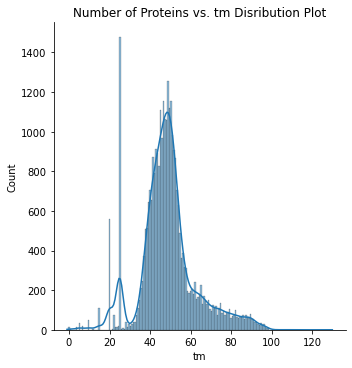

In [31]:
sns.displot(df['tm'], kde=True).set(title='Number of Proteins vs. tm Disribution Plot') # Let's see the distribution of the classifications 

#(tm is the enzyme melting point and is a measure of stability)

Here we create anouther distribution plot to see what the distrubution of pH looks like among proteins. It seems that the data has a massive peak around a pH of 7 and most of the data is concentrated at that peak and below. Note that pH is on a scal from 0-14. There were no pHs below 2, so we set the scale to start at 2 on the x axis. The plot looks normally distributed.

(2.0, 14.0)

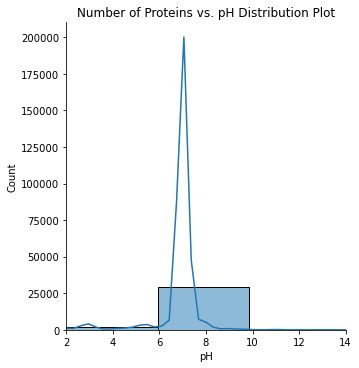

In [32]:
sns.displot(df['pH'], kde=True).set(title='Number of Proteins vs. pH Distribution Plot')
plt.xlim(right=14,left=2)

In [33]:
print(len(df), " Total Rows vs ", len(df["protein_sequence"].unique()), " Unique Sequences")

31390  Total Rows vs  28981  Unique Sequences


coorelation: -0.058987150915936856


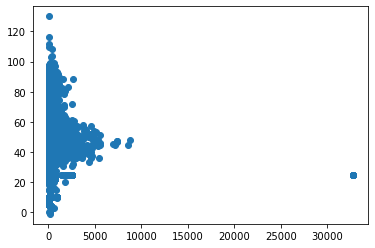

In [34]:
plt.scatter(df["protein_sequence"].apply(lambda x : len(x)), df["tm"])
print("coorelation: " + str(df["tm"].corr(df["protein_sequence"].apply(lambda x : len(x))))) 
# looks like no relation, we can ignore the length of sequences

In [35]:
# This is the base wild type sequence provided in the description of the competition

base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

## Parsing
The protein sequence feature is almost entirely made of of unique values, so we need to parse this into multiple more useful features. To do this, we will employ the PyRosseta library, which supplies funcitonality for dealing with molecular biology information. 

Using Rosetta's scoring, let's get the energy balance and number of atoms from each amino acid present in the base sequence. This will be useful later for numeralizing the mutations. Lower energies are more stable.

In [36]:
pyrosetta.init()
score_func = pyrosetta.get_score_function(True) # Used for scoring amino acids in pyRosetta
energy_dict = {}
atoms_dict = {}
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
for aa in amino_acids:
    pose = pose_from_sequence(str(aa), 'fa_standard') 
    energy_dict[aa] = score_func(pose)
    atoms_dict[aa] = pose.total_atoms()
    print(str(aa) + " - energy: " + str(energy_dict[aa]) + ", # atoms: " + str(atoms_dict[aa]))

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python39.linux 2022.49+release.201d7639f91f369d58b1adf514f3febaf6154c58 2022-12-07T16:15:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.linux r337 2022.49+release.201d763 201d7639f91f369d58b1adf514f3febaf6154c58 http://www.pyrosetta.org 2022-12-07T16:15:33
core.init: command: PyRosetta -ex1 -ex2aro -database /home/sho/anaconda3/lib/python3.9/site-packages/pyrosetta-2022.49+release.201d763-py3.9-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=54535753 seed_offset=0 real_seed=54535753
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=54535753 RG_type=mt19937
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
A - energy:

## Grouping Sequences
The train data contains thousands of sequences that are not grouped properly.
To assign an original wildtype sequence to the training data, we will emply the use of the train wildtype groups csv file containing all wiltypes present in the training data. 

In [37]:
wildtype_groups = pd.read_csv("train_wildtype_groups.csv") #https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af?select=train_wildtype_groups.csv 
wildtypes = wildtype_groups["wildtype"].unique()
len(wildtypes) # There are 78 unique wildtypes in the training data

78

To group each sequence into a wildtype group, we need to emply a string difference algorithm. We have chosen the levenshtein distance because we do not care about what place each character is in, just the amount of additions or deletions.

In [38]:

# Needs to be optimized perhaps using apply function or list comprehensions

df["wildtype"] = -1

def group_wildtypes(seq):
  for idx in range(len(wildtypes)):
    wt = wildtypes[idx]
    ld = levenshtein_distance(wt, seq)
    if ((len(seq) > (len(wt) - 6)) and (len(seq) < (len(wt) + 6))) and ld < 20:
      return int(idx)
      
df["wildtype"] = df["protein_sequence"].apply(group_wildtypes)

print(df["wildtype"].value_counts())
mutations = []
for row in df.iterrows():
  mutations.append(levenshtein_distance(wildtypes[row[1]["wildtype"]], row[1]["protein_sequence"]))
df["total_mutations"] = mutations

### Energy Calculations
Using the dictionaries for each amino acid and their energy and number of atoms, we will calculate the 

In [ ]:
def calc_energy(data):
  mutations = []
  energy_changes = []
  for row in data.iterrows():
    seq = row[1]["protein_sequence"]
    wt = wildtypes[row[1]["wildtype"]]
    diff = ""
    flag = False
    count = 0
    muts = []
    wts = []
    for i in range(min(len(wt), len(seq))):
      if (wt[i] != seq[i]):
        count = count + 1
        if not flag:
          muts.append(seq[i])
          wts.append(wt[i])
          diff = diff + str(i) + " "
          flag = True
        diff = diff + seq[i]
      else:
        if flag:
          diff = diff + " - "
          flag = False
    energy_change = 0
    for j in range(len(muts)):
      emut = energy_dict[muts[j]]
      ewt = energy_dict[wts[j]]
      nmut = atoms_dict[muts[j]]
      nwt = atoms_dict[wts[j]]
      e_bar = (emut/nmut - ewt/nwt) / (ewt/nwt) # Formula from study
      energy_change = energy_change + e_bar
    mutations.append(count)
    energy_changes.append(energy_change)
  data["total_mutations"] = mutations
  data["energy"] = energy_changes

calc_energy(df)

In [ ]:
df = df[df["wildtype"] != -1]
df

,seq_id,protein_sequence,pH,tm,wildtype,total_mutations,energy
266,266,AKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,58.0,25,1,-0.947064
972,972,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,45.2,8,1,1.607760
973,973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,7.0,8,1,1.607760
974,974,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,48.0,8,1,1.607760
981,981,DVSGTVCLSALPPEATDTLNLIASDGPFPFSQDGVVFQNRESVLPT...,7.0,25.0,8,1,0.467027
982,982,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...,7.0,31.8,8,1,-0.932215
983,983,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...,7.0,52.6,8,1,-0.932215
984,984,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...,7.0,25.0,8,1,-0.932215
985,985,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,7.0,43.8,8,1,1.607760
986,986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,48.4,7.0,8,1,1.607760


In [ ]:
# have to modify data a bit in order to run it through RF
df.dropna(axis=0,how='any',inplace=True)
df.drop(['wildtype','seq_id','protein_sequence'], axis=1, inplace=True)

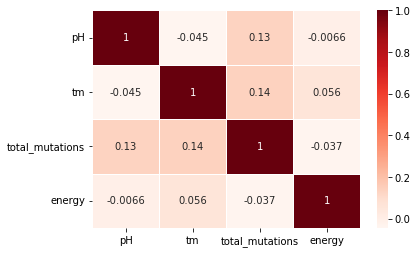

In [ ]:
# This shows us the correlation between columns
sns.heatmap(df.corr(),linewidths=1,cmap=plt.cm.Reds, annot=True)

In [ ]:
x=df.drop(['tm'],axis=1)
y=df['tm']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

In [ ]:

rf = RandomForestRegressor()
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
grid = {'max_depth':list(np.arange(1, 20, step=2)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,5, step=1),
              'min_samples_leaf':np.arange(1,6, step=1),
              'min_samples_split':np.arange(2, 12, step=2)
         }

In [ ]:
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=grid,
                              n_iter = 50, scoring='neg_mean_absolute_error', 
                              cv = 5, verbose=2,
                              return_train_score=True)

In [ ]:
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=7, max_features=1, min_samples_leaf=5, min_samples_split=4, n_estimators=160; total time=   1.0s
[CV] END max_depth=7, max_features=1, min_samples_leaf=5, min_samples_split=4, n_estimators=160; total time=   1.0s
[CV] END max_depth=7, max_features=1, min_samples_leaf=5, min_samples_split=4, n_estimators=160; total time=   1.0s
[CV] END max_depth=7, max_features=1, min_samples_leaf=5, min_samples_split=4, n_estimators=160; total time=   1.1s
[CV] END max_depth=7, max_features=1, min_samples_leaf=5, min_samples_split=4, n_estimators=160; total time=   1.0s
[CV] END max_depth=5, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=460; total time=   4.8s
[CV] END max_depth=5, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=460; total time=   4.8s
[CV] END max_depth=5, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=460; total time=   4.7s
[CV] END m

/home/sho/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sho/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sho/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/sho/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/sho/anaconda3/lib/

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_features': array([1, 2, 3, 4]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460])},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
# Get submission turn to csv for submitting
# Next step is to run predict on test and look at prediction and get spearman
test_df = pd.read_csv('test.csv')
submission = pd.DataFrame()
submission = test_df['seq_id']
get_levdist(test_df)
calc_energy(test_df)
test_df.drop(columns=['wildtype','seq_id','protein_sequence'], axis=1, inplace=True)
submission['tm'] = grid_search.predict(test_df)
submission.to_csv('submission.csv',index=False)
submission

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [ ]:
pred = grid_search.predict(x_test)
stats.spearmanr(y_test, pred)